In [1]:
from Functions import *
import winsound

# Preliminary

In [2]:
def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=141.6, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=5e-3, N=512)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + HRM_devices
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### 1. common simulation parameters

In [3]:
##### ''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 11215        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650
}

##### common simulation parameters
m1_p = 185.0     # mirror 1 source distance

# calculate beam size at mirror 1
wavelength = 1239.84193e-9/E0
Rayleigh_length = np.pi*beam_params['sigma_x']**2/wavelength
beam_width_z = 2.35*beam_params['sigma_x'] * np.sqrt(1+np.square((m1_p)/Rayleigh_length))    # 2 x FWHM

# estimate m2_p geometrically
m2_p = 2.65e-3/(2.65e-3-beam_width_z)*115
m1_q = 115.0 - m2_p
print(m1_p, m1_q, m2_p)

f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 6.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [4,4,0]; alphaAsym2 = 32.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_plot = dir_out+'{}eV_{}_{}-{}_{}-{}_{}mm/'.format(E0, HHLM_type,
                                          hkl1[0]*100+hkl1[1]*10+hkl1[2], alphaAsym1,
                                          hkl2[0]*100+hkl2[1]*10+hkl2[2], alphaAsym2,
                                          HHLM_offset*1e3); make_dir(dir_plot)
print('\nCWD:',dir_plot)

185.0 -38.708938008099835 153.70893800809984
path exists
path exists

CWD: output/11215eV_2DCM_111-6.0_440-32.0_20.0mm/


### 2. calculate crystal dimensions and slit width

In [4]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [5]:
# get crytal properties
beta0s = []; braggs = []; asyms = []; OE_z = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))
        OE_z.append(device.z)

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm'.format(np.round(l_crystal*1e3/2, 3)))
print('position: {} m\n'.format(np.round(OE_z, 5)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [10.157 10.155 35.158 35.154 35.154 35.154]
asymmetry: [ -6.   6. -32.  32.   0.  15.]
beam size: [ 5.094  1.328 22.201  1.337  1.337  0.6  ] mm
footprint: [18.31  18.31  24.092 24.099  2.322  1.742] mm
position: [955.      955.05403 955.25403 955.26118 960.      960.05   ] m

calculated slit width: 0.86um
actual slit width: 3.0um



### M2_p optimization (perfect case)

In [6]:
%%capture capt
n_loop = 31
# log_m2_p = np.linspace(-0.1, 0.1, n_loop) + np.log10(m2_p)
# m2_p_list = 10**log_m2_p
# xscale = 'log'

m2_p_list = np.linspace(-10,10,n_loop) + m2_p
xscale = 'linear'

pulse_duration = np.zeros_like(m2_p_list)
pulse_tilt = np.zeros_like(m2_p_list)
spatial_chirp = np.zeros_like(m2_p_list)
energy_bandwidth = np.zeros_like(m2_p_list)
throughput = np.zeros_like(m2_p_list)

if os.path.exists(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6)):
    print('perfect case already simulated, skipping to plots')
else:
    for i in range(n_loop):
        mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p_list[i],
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

        screen_names = ['im_input','im_out']

        beam_params['photonEnergy'] = E0
        pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=100)
        
        try:
            pulse.propagate(beamline=mono_beamline_p,screen_names=screen_names)
        except:
            pulse_duration[i] = 1e5
            pulse_tilt[i] = 1e5
            spatial_chirp[i] = 1e5
            energy_bandwidth[i] = 1e5
            throughput[i] = 0
            continue
        
        try:
            c, pulse_duration[i] = pulse.pulse_duration('im_out')
        except:
            pulse_duration[i] = 1e5
        
        try:
            pulse_tilt[i] = pulse.pulsefront_tilt('im_out')
        except:
            pulse_tilt[i] = 1e5
        try:
            spatial_chirp[i] = pulse.spatial_chirp('im_out')
        except:
            spatial_chirp[i] = 1e5
        try:
            energy_bandwidth[i] = pulse.pulse_bandwidth('im_out')
        except:
            energy_bandwidth[i] = 1e5
        try:
            throughput[i] = pulse.throughput('im_input','im_out')
        except:
            throughput[i] = 0

    with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'w') as f:
        f.create_dataset('m2_p', data=m2_p_list)
        f.create_dataset('pulse_duration', data=pulse_duration)
        f.create_dataset('tilt', data=pulse_tilt)
        f.create_dataset('chirp', data=spatial_chirp)
        f.create_dataset('bandwidth', data=energy_bandwidth)
        f.create_dataset('throughput', data=throughput)

winsound.Beep(1500, 1000)

output/11215eV_2DCM_111-6.0_440-32.0_20.0mm/
left 153.70893800809984, right 154.3756046747665, result 154.02912324967807
154.02912324967807


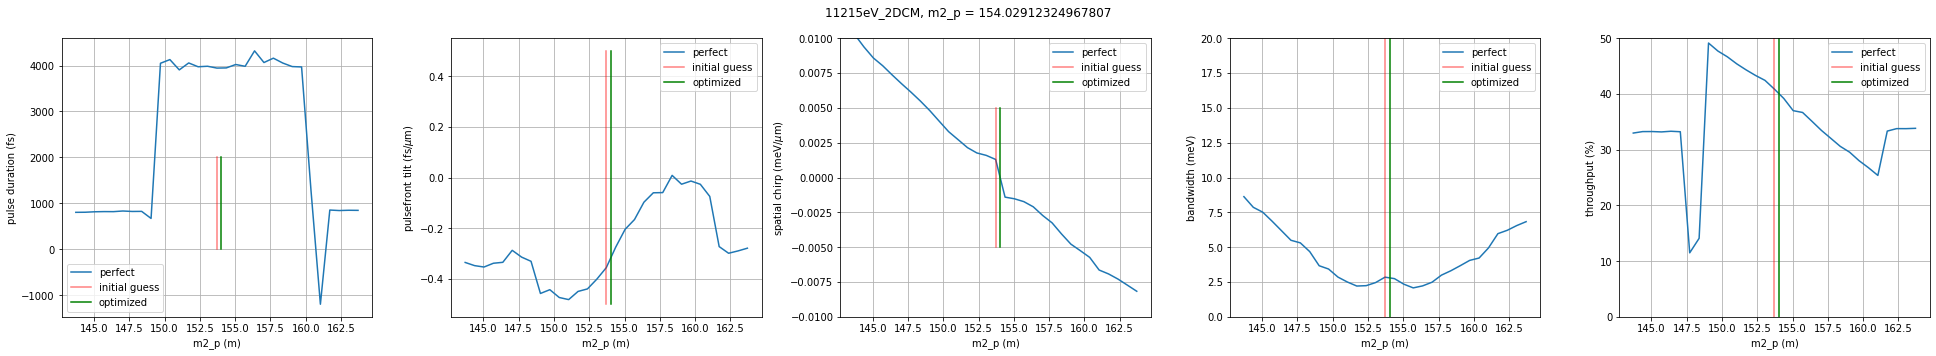

In [13]:
##### m2_p optimization (perfect case)
with h5py.File(dir_plot+'perfect_{}um_slit.h5'.format(slit_width*1e6), 'r') as f:
    m2_p_list = f['m2_p'][:]
    pulse_duration0 = f['pulse_duration'][:]
    pulse_tilt0 = f['tilt'][:]
    spatial_chirp0 = f['chirp'][:]
    energy_bandwidth0 = f['bandwidth'][:]
    throughput0 = f['throughput'][:]

plot_axis_x0 = m2_p_list
plot_label_x0 = 'm2_p (m)'
plot_legend0 = 'perfect'
    
print(dir_plot)
try:
    result = find_zero(plot_axis_x0, spatial_chirp0, direction='decrease', x_i=150, x_f=170)
    print(result)
except:
    result = plot_axis_x0[energy_bandwidth0.argmin()]

plt.figure(figsize=(27,5))
plt.suptitle('{}eV_{}, m2_p = {}'.format(E0, HHLM_type, result))

plt.subplot(1,5,1)
plt.plot(plot_axis_x0, pulse_duration0,label=plot_legend0)
plt.plot([m2_p, m2_p], [0, 2e3], 'r-', alpha=0.5, label='initial guess')
plt.plot([result, result], [0, 2e3], 'g-', alpha=1.0, label='optimized')
plt.xlabel(plot_label_x0); plt.ylabel('pulse duration (fs)')
plt.grid(); plt.legend(); plt.tight_layout(); plt.xscale(xscale)
# plt.ylim([0, 2e3])

plt.subplot(1,5,2)
plt.plot(plot_axis_x0, pulse_tilt0,label=plot_legend0)
plt.plot([m2_p, m2_p], [-0.5, 0.5], 'r-', alpha=0.5, label='initial guess')
plt.plot([result, result], [-0.5, 0.5], 'g-', alpha=1.0, label='optimized')
plt.xlabel(plot_label_x0); plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout(); plt.xscale(xscale)
# plt.ylim([-0.5,0.5])

plt.subplot(1,5,3)
plt.plot(plot_axis_x0, spatial_chirp0*1000,label=plot_legend0)
plt.plot([m2_p, m2_p], [-5e-3, 5e-3], 'r-', alpha=0.5, label='initial guess')
plt.plot([result, result], [-5e-3, 5e-3], 'g-', alpha=1.0, label='optimized')
plt.xlabel(plot_label_x0); plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout(); plt.xscale(xscale)
plt.ylim([-1e-2, 1e-2])

plt.subplot(1,5,4)
plt.plot(plot_axis_x0, energy_bandwidth0*1000,label=plot_legend0)
plt.plot([m2_p, m2_p], [-5, 50], 'r-', alpha=0.5, label='initial guess')
plt.plot([result, result], [-5, 50], 'g-', alpha=1.0, label='optimized')
plt.xlabel(plot_label_x0); plt.ylabel('bandwidth (meV)')
plt.grid(); plt.legend(); plt.tight_layout(); plt.xscale(xscale)
plt.ylim([0, 20])

plt.subplot(1,5,5)
plt.plot(plot_axis_x0, throughput0*100,label=plot_legend0)
plt.plot([m2_p, m2_p], [-5,105], 'r-', alpha=0.5, label='initial guess')
plt.plot([result, result], [-5,105], 'g-', alpha=1.0, label='optimized')
plt.xlabel(plot_label_x0); plt.ylabel('throughput (%)')
plt.grid(); plt.legend(); plt.tight_layout(); plt.xscale(xscale)
plt.ylim([0, 50])

plt.savefig(dir_plot+'m2_p_optimization.png')


In [8]:
import winsound
winsound.Beep(1500, 3000)